# This notebook creates Figure 3

In [1]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
# import cmocean as cmo
from scipy.stats import linregress
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from typing import Tuple, List

from matplotlib.gridspec import GridSpec

In [2]:
def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    # print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, _, nlon, ntime = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        nlats = int(len(latcoords) - j) # nlats below diag
        ctos[:,:nlats,i,:] = np.full((nmodel, nlats,ntime), np.nan) 
        
        jold = j
    
    return ctos

In [3]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

SEB_CMIP6 = xr.open_dataset("data/piControl/SEB_CMIP6_full.nc")*3
SEB_CMIP5 = xr.open_dataset("data/piControl/SEB_CMIP5_full.nc")*3
SEB_CMIP6["NON_CLOUD"] = SEB_CMIP6["SW_Other"] - SEB_CMIP6["LW_Other"]
SEB_CMIP5["NON_CLOUD"] = SEB_CMIP5["SW_Other"] - SEB_CMIP5["LW_Other"]
shared_models_cmip6 = SEB_CMIP6.model.values
shared_models_cmip5 = SEB_CMIP5.model.values
print(SEB_CMIP6)

ERA = "CMIP6"
U10_CMIP6 = xr.open_dataarray(f"data/piControl/rolling_gradient_U10_{ERA}.nc")*3
V10_CMIP6 = xr.open_dataarray(f"data/piControl/rolling_gradient_V10_{ERA}.nc")*3
 
U10_CMIP6 = fix_coords(U10_CMIP6.rename("U10").to_dataset())
V10_CMIP6 = fix_coords(V10_CMIP6.rename("V10").to_dataset())

SEB_CMIP6

<xarray.Dataset>
Dimensions:    (model: 35, lat: 72, lon: 144, time: 120, bnds: 2)
Coordinates:
  * model      (model) object 'GISS-E2-1-G' 'EC-Earth3-LR' ... 'CMCC-CM2-SR5'
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
Dimensions without coordinates: bnds
Data variables: (12/20)
    NET        (model, time, lat, lon) float64 nan nan nan ... 2.843 2.852 2.845
    O          (model, time, lat, lon) float64 nan nan nan ... 0.6065 0.2702
    W          (model, time, lat, lon) float64 nan nan nan ... 0.008707 0.01837
    RH         (model, time, lat, lon) float64 nan nan ... -0.0002415 -0.0002398
    DT         (model, time, lat, lon) float64 nan nan nan ... 0.8565 0.8549
    LH_Other   (model, time, lat, lon) float64 nan nan nan ... 0.865 0.8731
    ...         ...
    SW_Other   (model, time, lat, l

<xarray.Dataset>
Dimensions:    (model: 35, lat: 72, lon: 144, time: 120, bnds: 2)
Coordinates:
  * model      (model) object 'GISS-E2-1-G' 'EC-Earth3-LR' ... 'CMCC-CM2-SR5'
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
Dimensions without coordinates: bnds
Data variables: (12/20)
    NET        (model, time, lat, lon) float64 nan nan nan ... 2.843 2.852 2.845
    O          (model, time, lat, lon) float64 nan nan nan ... 0.6065 0.2702
    W          (model, time, lat, lon) float64 nan nan nan ... 0.008707 0.01837
    RH         (model, time, lat, lon) float64 nan nan ... -0.0002415 -0.0002398
    DT         (model, time, lat, lon) float64 nan nan nan ... 0.8565 0.8549
    LH_Other   (model, time, lat, lon) float64 nan nan nan ... 0.865 0.8731
    ...         ...
    SW_Other   (model, time, lat, lon) float64 nan nan nan ... 11.21 11.4 11.46
    EIS        (model, time, lat, lon) float64 0.0 0.0 0.0 ... -3.701 -3.689
    lon_bnds   (lon, bnds) float64 -540.0 -532.5 -532.5 ... 532.5 532.5 -540.0
    lat_bnds   (lat, bnds) float64 -270.0 -262.5 -262.5 ... 262.5 262.5 270.0
    time_bnds  (time, bnds) float64 -1.5 1.5 1.5 4.5 ... 352.5 355.5 355.5 358.5
    NON_CLOUD  (model, time, lat, lon) float64 nan nan nan ... 19.75 19.93 20.01

In [4]:
# Load Rolling Gradient for Regions TOS CMIP6
SST_T_EPSA_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificSA_trend.nc").sel(model=shared_models_cmip6)
SST_T_WE_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_WE-Trend.nc").sel(model=shared_models_cmip6)
SST_T_E_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacific_trend.nc").sel(model=shared_models_cmip6)
SST_T_SO_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc").sel(model=shared_models_cmip6)
SST_T_EPT_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc").sel(model=shared_models_cmip6)

# Load Rolling Gradient for Regions TOS CMIP5
SST_T_EPSA_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificSA_trend.nc").sel(model=shared_models_cmip5)
SST_T_WE_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_WE-Trend.nc").sel(model=shared_models_cmip5)
SST_T_E_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacific_trend.nc").sel(model=shared_models_cmip5)
SST_T_SO_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_southernOcean_trend.nc").sel(model=shared_models_cmip5)
SST_T_EPT_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc").sel(model=shared_models_cmip5)

SST_T_EPT_CMIP6

<xarray.DataArray (model: 35, time: 120)>
[4200 values with dtype=float64]
Coordinates:
  * model    (model) object 'GISS-E2-1-G' 'EC-Earth3-LR' ... 'CMCC-CM2-SR5'
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119

In [5]:
def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)
    
SWCF_CMIP6 = xr.open_dataarray("data/piControl/swcf_east_sa_cmip6_v3.nc")
SWCF_CMIP5 = xr.open_dataarray("data/piControl/swcf_east_sa_cmip5_v3.nc")

SWCF_CMIP6, SEB_CMIP6 = get_shared_models(SWCF_CMIP6, SEB_CMIP6)
SWCF_CMIP5, SEB_CMIP5 = get_shared_models(SWCF_CMIP5, SEB_CMIP5)
SWCF_CMIP6

<xarray.DataArray 'swcf' (model: 34)>
[34 values with dtype=float64]
Coordinates:
  * model    (model) object 'EC-Earth3-Veg-LR' 'INM-CM4-8' ... 'GFDL-CM4'

In [6]:
def get_barplot_correlations(swcf_cmip: xr.Dataset,seb_cmip: xr.Dataset) -> List:
    """_summary_

    Args:
        seb_cmip (_type_): _description_
    Returns:
    """
    data_vars = list(SEB_CMIP6.data_vars.keys())
    data_vars = [i for i in data_vars if i not in ["lon_bnds", "lat_bnds", "time_bnds", "time", "lon", "lat"]]

    # Get NET SEB STD
    ept_net = get_triangle(seb_cmip["NET"])
    ept_net = fix_coords(ept_net.rename("NET").to_dataset()).spatial.average("NET")["NET"]
    ept_net = ept_net.std("time")

    data = {}
    p = {}
    for cvar in data_vars:
        ept_cvar = get_triangle(seb_cmip[cvar])
        ept_cvar = fix_coords(ept_cvar.rename(cvar).to_dataset()).spatial.average(cvar)[cvar]
        ept_cvar = ept_cvar.std("time")
        
        res_seb = linregress(ept_net.values, ept_cvar.values)
        res_swcf = linregress(swcf_cmip.values, ept_cvar.values)

        data[cvar] = [res_seb.rvalue, res_swcf.rvalue]
        p[cvar] = [res_seb.pvalue, res_swcf.pvalue]

    return data, p


corr_cmip6, p_cmip6 = get_barplot_correlations(SWCF_CMIP6, SEB_CMIP6)
corr_cmip5, p_cmip5 = get_barplot_correlations(SWCF_CMIP6, SEB_CMIP6)

corr_cmip, p_cmip = get_barplot_correlations(
    swcf_cmip=xr.concat([SWCF_CMIP6, SWCF_CMIP5], dim="model"), 
    seb_cmip=xr.concat([SEB_CMIP6, SEB_CMIP5], dim="model")
)
corr_cmip

{'NET': [1.0, 0.55306735528018],
 'O': [0.38701990180230794, -0.13677147748778762],
 'W': [0.8047366911485593, 0.5797523689778521],
 'RH': [-0.2661834032477051, -0.19101415752921036],
 'DT': [0.448691923045264, 0.09330033696881804],
 'LH_Other': [0.8221314821899055, 0.6212578496505554],
 'SH': [-0.07976408453991218, -0.24061175340554566],
 'SW': [0.21403547022759728, 0.14088193926986994],
 'LW': [0.2536800352165422, 0.2169133824319148],
 'SWC': [0.2771087064482165, 0.33547191655940817],
 'LWC': [0.36838405949004394, 0.5215430997209201],
 'TOS': [0.7589300350592615, 0.6953613755670889],
 'CLOUD': [0.04218535427618385, -0.11016845810936424],
 'LW_Other': [0.2550065820421003, 0.2452946219299984],
 'SW_Other': [0.6626661450848653, 0.4082839049116397],
 'EIS': [0.7179670188467784, 0.7123173020480079],
 'NON_CLOUD': [0.47067642087509465, 0.38718101433920504]}

In [7]:
SEB_CMIP6, SST_T_EPT_CMIP6 = get_shared_models(SEB_CMIP6, SST_T_EPT_CMIP6)
SEB_CMIP5, SST_T_EPT_CMIP5 = get_shared_models(SEB_CMIP5, SST_T_EPT_CMIP5)

U10_CMIP6, SEB_CMIP6 = get_shared_models(U10_CMIP6, SEB_CMIP6)
V10_CMIP6, SEB_CMIP6 = get_shared_models(V10_CMIP6, SEB_CMIP6)

SWCF_CMIP6, SEB_CMIP6 = get_shared_models(SWCF_CMIP6, SEB_CMIP6)
SWCF_CMIP5, SEB_CMIP5 = get_shared_models(SWCF_CMIP5, SEB_CMIP5)

In [8]:
def get_area_averages(SST_T_EPT_CMIP6):
    """Get area averages for each flux for EPSA and EPT"""
    # iterate through each flux
    flux_ept = []
    flux_epsa = []
    for flux in ["NET", "O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD", "DT", "RH", "W"]:
        # EPT Area Average
        EPT = get_triangle(SEB_CMIP6[flux])
        flux_ept.append(fix_coords(EPT.rename(flux).to_dataset()).spatial.average(flux)[flux])
        # EPSA Area Average 
        EPSA = SEB_CMIP6[flux].sel(lon=slice(-105, -70), lat=slice(-40, -10)) 
        flux_epsa.append(fix_coords(EPSA.rename(flux).to_dataset()).spatial.average(flux)[flux])

    # Merge into one dataset
    SEB_CMIP6_EPT = xr.merge(flux_ept)
    SEB_CMIP6_EPSA = xr.merge(flux_epsa)

    # Get shared models with SST trends
    SEB_CMIP6_EPT, SST_T_EPT_CMIP6 = get_shared_models(SEB_CMIP6_EPT, SST_T_EPT_CMIP6)
    SEB_CMIP6_EPSA, SST_T_EPT_CMIP6 = get_shared_models(SEB_CMIP6_EPSA, SST_T_EPT_CMIP6)

    SEB_CMIP6_EPT

    return SEB_CMIP6_EPT, SEB_CMIP6_EPSA, SST_T_EPT_CMIP6

SEB_CMIP6_EPT, SEB_CMIP6_EPSA, SST_T_EPT_CMIP6 = get_area_averages(SST_T_EPT_CMIP6)

# Prep 1-sigma SO 30-year trends - Figure 4 Data

In [22]:
SEB_CMIP6_SO = SEB_CMIP6.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("NET")["NET"]
SO_Thres =  SEB_CMIP6_SO.mean("time") - SEB_CMIP6_SO.std("time")
SEB_SO_1sig = SEB_CMIP6.where(SEB_CMIP6_SO <= SO_Thres).mean(["time", "model"])
U10_SO_1sig = U10_CMIP6.where(SEB_CMIP6_SO <= SO_Thres).mean(["time", "model"])
V10_SO_1sig = V10_CMIP6.where(SEB_CMIP6_SO <= SO_Thres).mean(["time", "model"])

# Prep 1-sigma 30-year Trends - Figure S3 Data

In each model,

compute all possible 30-year trends in EPT SST, yielding a distribution of trends (a vector with units K/30yrs).

normalize this distribution by its standard deviation (a vector with units K/30 yrs) such that it is in sigma units

for each SFC energy budget component map:

regress each trend map (with units K/30yrs) on this normalized vector, yielding a trend map in units of K/30yrs per sigma

Average these maps across models, yielding the composite 1-sigma maps.

 

Somewhere in the above steps a negative sign gets introduced as well so as to make it applicable for a 1-sigma cooling event.

In [36]:
#### NEW: 02/29 ####
def regression_coeffs(ds_map, ds):
    """
    Calculate the regression coefficient between a time series of 30-year trends and a 
    map of 30-year trends. Then multiply by 1-sigma to get the 1-sigma regression coefficient.
    """
    # First standardize the data
    ds = (ds - ds.mean("time")) / ds.std('time')
    
    # METHOD 1: Composite Analysis - Get times from map where ds is less than 1 sigma
    # map = xr.where(ds <= -1., ds_map, np.nan)
    # map = map.mean("time")
    
    # Method 2: Regression Coefficient
    map = xscore.linslope(ds, ds_map, dim='time', skipna=True)
    
    return -map

# Drop lat_bnds, lon_bnds, time_bnds
SEB_CMIP6_nbnds = SEB_CMIP6.drop(["lat_bnds", "lon_bnds", "time_bnds"])
U10_CMIP6_nbnds = U10_CMIP6.drop(["lat_bnds", "lon_bnds", "time_bnds"])
V10_CMIP6_nbnds = V10_CMIP6.drop(["lat_bnds", "lon_bnds", "time_bnds"])

SEB_CMIP6_1sig = regression_coeffs(ds_map=SEB_CMIP6_nbnds, ds=SEB_CMIP6_EPT["NET"]).mean("model")
U10_CMIP6_1sig = regression_coeffs(ds_map=U10_CMIP6_nbnds, ds=SEB_CMIP6_EPT["NET"]).mean("model")
V10_CMIP6_1sig = regression_coeffs(ds_map=V10_CMIP6_nbnds, ds=SEB_CMIP6_EPT["NET"]).mean("model")
SEB_CMIP6_EPSA_STD = regression_coeffs(ds_map=SEB_CMIP6_EPSA, ds=SEB_CMIP6_EPT["NET"])
SEB_CMIP6_EPT_STD = regression_coeffs(ds_map=SEB_CMIP6_EPT, ds=SEB_CMIP6_EPT["NET"])

fluxes = ["NET", "O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD", "DT", "RH", "W"]
sig_SEB = {}
for flux in fluxes:
    sig_SEB[flux] = (float(SEB_CMIP6_EPT_STD[flux].mean(["model"]).values), float(SEB_CMIP6_EPSA_STD[flux].mean(["model"]).values))
sig_SEB

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

{'NET': (-0.19690832115138066, -0.18111444324189085),
 'O': (-0.12233382106574667, -0.06298215319142103),
 'LH_Other': (-0.10261004145352433, -0.10533695372640989),
 'SH': (-0.007627820497674539, 0.014044892370712351),
 'SWC': (0.00022060013188826555, -0.0362271259554428),
 'LWC': (0.02605748126969202, 0.049499032425376635),
 'CLOUD': (0.026278081401580285, 0.013271906469933824),
 'NON_CLOUD': (0.044711734369762265, 0.07850496335471155),
 'DT': (0.013501163970194472, 0.0013372568796184469),
 'RH': (4.283679240559837e-05, 2.872020732158438e-05),
 'W': (-0.11598760301190515, -0.10590047794151845)}

In [26]:
# #### OLD METHOD ####
# # Composite All time periods where we have a negative 1 sigma anomaly in EPT
# EPT_NET_Thres =  SEB_CMIP6_EPT["NET"].mean("time") - SEB_CMIP6_EPT["NET"].std("time")
# EPSA_NET_Thres =  SEB_CMIP6_EPSA["NET"].mean("time") - SEB_CMIP6_EPSA["NET"].std("time")

# # S3: Composites on 1sigma EPT Anom
# Threshold = EPT_NET_Thres
# Region = SEB_CMIP6_EPT["NET"]

# # S4: Composites on 1sigma EPSA Anom
# # Threshold = EPSA_NET_Thres
# # Region = SEB_CMIP6_EPSA["NET"]

# SEB_CMIP6_1sig = SEB_CMIP6.where(Region <= Threshold).mean(["time", "model"])
# U10_CMIP6_1sig = U10_CMIP6.where(Region <= Threshold).mean(["time", "model"])
# V10_CMIP6_1sig = V10_CMIP6.where(Region <= Threshold).mean(["time", "model"])
# SEB_CMIP6_1sig_EPT = SEB_CMIP6_EPT.where(SEB_CMIP6_EPT["NET"] <= EPSA_NET_Thres).mean(["time", "model"])
# SEB_CMIP6_1sig_EPSA = SEB_CMIP6_EPSA.where(SEB_CMIP6_EPSA["NET"] <= EPSA_NET_Thres).mean(["time", "model"])
# SEB_CMIP6_1sig_EPSA

# fluxes = ["NET", "O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD", "DT", "RH", "W"]
# sig_SEB = {}
# for flux in fluxes:
#     sig_SEB[flux] = (float(SEB_CMIP6_1sig_EPT[flux].values), float(SEB_CMIP6_1sig_EPSA[flux].values))
# sig_SEB
# SEB_CMIP6_1sig

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, bnds: 2)
Coordinates:
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
Dimensions without coordinates: bnds
Data variables: (12/20)
    NET        (lat, lon) float64 -0.9574 -1.095 -0.8239 ... 0.1531 0.1649 0.184
    O          (lat, lon) float64 -0.3007 -0.2477 -0.4522 ... 0.2518 0.2379
    W          (lat, lon) float64 -0.02073 -0.01547 ... 0.01016 0.01143
    RH         (lat, lon) float64 -4.518e-05 -4.646e-05 ... 5.933e-05 5.937e-05
    DT         (lat, lon) float64 -0.1746 -0.1791 -0.1673 ... -0.05198 -0.05156
    LH_Other   (lat, lon) float64 -0.2418 -0.2392 -0.2118 ... -0.05026 -0.0485
    ...         ...
    SW_Other   (lat, lon) float64 3.575 1.945 3.758 ... 0.2761 0.289 0.3239
    EIS        (lat, lon) float64 0.07874 0.09319 0.07753 ... 0.114 0.1195
    lon_bnds   (lon, bnds) float64 -540.0 -532.5 -532.5 ... 532.5 532.5 -540.0
    lat_bnds   (lat, bnds) float64 -270.0 -262.5 -262.5 ... 262.5 262.5 270.0
    time_bnds  (bnds) float64 172.0 175.0
    NON_CLOUD  (lat, lon) float64 0.07598 -2.784 0.3797 ... -0.3737 -0.368

# Prep Grouped by SWCF - Figure 3 Data

In [37]:
bottom_half_swcf = SWCF_CMIP6[SWCF_CMIP6 < SWCF_CMIP6.median()]
top_half_swcf =SWCF_CMIP6[SWCF_CMIP6 >= SWCF_CMIP6.median()]

# Drop lat_bnds, lon_bnds, time_bnds
SEB_CMIP6_nbnds = SEB_CMIP6.drop(["lat_bnds", "lon_bnds", "time_bnds"])
U10_CMIP6_nbnds = U10_CMIP6.drop(["lat_bnds", "lon_bnds", "time_bnds"])
V10_CMIP6_nbnds = V10_CMIP6.drop(["lat_bnds", "lon_bnds", "time_bnds"])

SEB_CMIP6_1sig_m = regression_coeffs(ds_map=SEB_CMIP6_nbnds, ds=SEB_CMIP6_EPT["NET"]) #.mean("model")
U10_CMIP6_1sig_m = regression_coeffs(ds_map=U10_CMIP6_nbnds, ds=SEB_CMIP6_EPT["NET"]) #.mean("model")
V10_CMIP6_1sig_m = regression_coeffs(ds_map=V10_CMIP6_nbnds, ds=SEB_CMIP6_EPT["NET"]) #.mean("model")

# Select SST_T_EPT_CMIP6 models that are in the bottom half of SWCF_CMIP6 
# sstb = SST_T_EPT_CMIP6.sel(model=bottom_half_swcf.model)
sebb = SEB_CMIP6_1sig_m.sel(model=bottom_half_swcf.model)
u10b = U10_CMIP6_1sig_m.sel(model=bottom_half_swcf.model)
v10b = V10_CMIP6_1sig_m.sel(model=bottom_half_swcf.model)

# sstt = SST_T_EPT_CMIP6.sel(model=top_half_swcf.model)
sebt = SEB_CMIP6_1sig_m.sel(model=top_half_swcf.model)
u10t = U10_CMIP6_1sig_m.sel(model=top_half_swcf.model)
v10t = V10_CMIP6_1sig_m.sel(model=top_half_swcf.model)

seb_dif = sebt.mean(["model"]) - sebb.mean(["model"])
v10_dif = v10t.mean(["model"]) - v10b.mean(["model"])
u10_dif = u10t.mean(["model"]) - u10b.mean(["model"])
seb_dif

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144)
Coordinates:
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
Data variables: (12/17)
    NET        (lat, lon) float64 -0.6105 -0.7895 -0.4626 ... -1.222 -1.217
    O          (lat, lon) float64 0.5364 0.4795 0.2913 ... -0.03015 -0.00697
    W          (lat, lon) float64 0.05198 0.05445 0.05357 ... 0.05691 0.05742
    RH         (lat, lon) float64 4.257e-05 4.22e-05 ... 1.491e-05 1.439e-05
    DT         (lat, lon) float64 -0.1811 -0.183 -0.1887 ... -0.3793 -0.3795
    LH_Other   (lat, lon) float64 -0.1017 -0.1003 -0.1001 ... -0.3779 -0.3776
    ...         ...
    TOS        (lat, lon) float64 0.0 0.0 0.0 ... -0.001629 -0.001649 -0.002175
    CLOUD      (lat, lon) float64 -16.38 -14.84 -14.3 ... -1.015 -1.03 -1.066
    LW_Other   (lat, lon) float64 18.89 17.95 15.95 15.54 ... 1.694 1.748 1.798
    SW_Other   (lat, lon) float64 0.3086 -0.3663 1.654 ... -3.15 -3.21 -3.246
    EIS        (lat, lon) float64 -0.06295 -0.05323 -0.04793 ... 0.6787 0.6902
    NON_CLOUD  (lat, lon) float64 -18.58 -18.32 -14.3 ... -4.845 -4.958 -5.044

In [23]:
# bottom_half_swcf = SWCF_CMIP6[SWCF_CMIP6 < SWCF_CMIP6.median()]
# top_half_swcf =SWCF_CMIP6[SWCF_CMIP6 >= SWCF_CMIP6.median()]

# # Select SST_T_EPT_CMIP6 models that are in the bottom half of SWCF_CMIP6 
# # sstb = SST_T_EPT_CMIP6.sel(model=bottom_half_swcf.model)
# sstb = SEB_CMIP6_EPT["NET"].sel(model=bottom_half_swcf.model)
# sebb = SEB_CMIP6.sel(model=bottom_half_swcf.model)
# u10b = U10_CMIP6.sel(model=bottom_half_swcf.model)
# v10b = V10_CMIP6.sel(model=bottom_half_swcf.model)
# threshold_b = sstb.mean("time") - sstb.std("time")
# sebb = sebb.where(sstb <= threshold_b)
# u10b = u10b.where(sstb <= threshold_b)
# v10b = v10b.where(sstb <= threshold_b) 

# # sstt = SST_T_EPT_CMIP6.sel(model=top_half_swcf.model)
# sstt = SEB_CMIP6_EPT["NET"].sel(model=top_half_swcf.model)
# sebt = SEB_CMIP6.sel(model=top_half_swcf.model)
# u10t = U10_CMIP6.sel(model=top_half_swcf.model)
# v10t = V10_CMIP6.sel(model=top_half_swcf.model)
# threshold_t = -sstt.mean("time") -sstt.std("time")
# sebt = sebt.where(sstt <= threshold_t)
# u10t = u10t.where(sstt <= threshold_t)
# v10t = v10t.where(sstt <= threshold_t)

# seb_dif = sebt.mean(["time", "model"]) - sebb.mean(["time", "model"])
# v10_dif = v10t.mean(["time", "model"]) - v10b.mean(["time", "model"])
# u10_dif = u10t.mean(["time", "model"]) - u10b.mean(["time", "model"])

# # seb_dif = sebt.std(["time"]).mean("model") - sebb.std(["time"]).mean("model")
# # v10_dif = v10t.std(["time"]).mean("model") - v10b.std(["time"]).mean("model")
# # u10_dif = u10t.std(["time"]).mean("model") - u10b.std(["time"]).mean("model")
# # u10dif
# seb_dif

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, bnds: 2)
Coordinates:
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
Dimensions without coordinates: bnds
Data variables: (12/20)
    NET        (lat, lon) float64 -0.9155 -0.6508 -0.03256 ... -1.988 -1.996
    O          (lat, lon) float64 0.9776 0.9142 0.1001 ... -4.302 -4.45 -4.492
    W          (lat, lon) float64 -0.03027 -0.02426 ... 0.01041 0.01246
    RH         (lat, lon) float64 0.0001445 0.0001492 ... -5.922e-06 -6.67e-06
    DT         (lat, lon) float64 -0.308 -0.3073 -0.345 ... -0.5719 -0.5724
    LH_Other   (lat, lon) float64 -0.2816 -0.2649 -0.27 ... -0.6657 -0.6645
    ...         ...
    SW_Other   (lat, lon) float64 6.624 7.31 12.38 ... -1.186 -1.224 -1.234
    EIS        (lat, lon) float64 -0.05868 -0.05471 0.01816 ... 0.8769 0.8956
    lon_bnds   (lon, bnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lat_bnds   (lat, bnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    time_bnds  (bnds) float64 -16.96 -16.96
    NON_CLOUD  (lat, lon) float64 -5.301 -3.846 5.519 ... -4.816 -4.961 -5.07

# Wind Break Down - Supplement

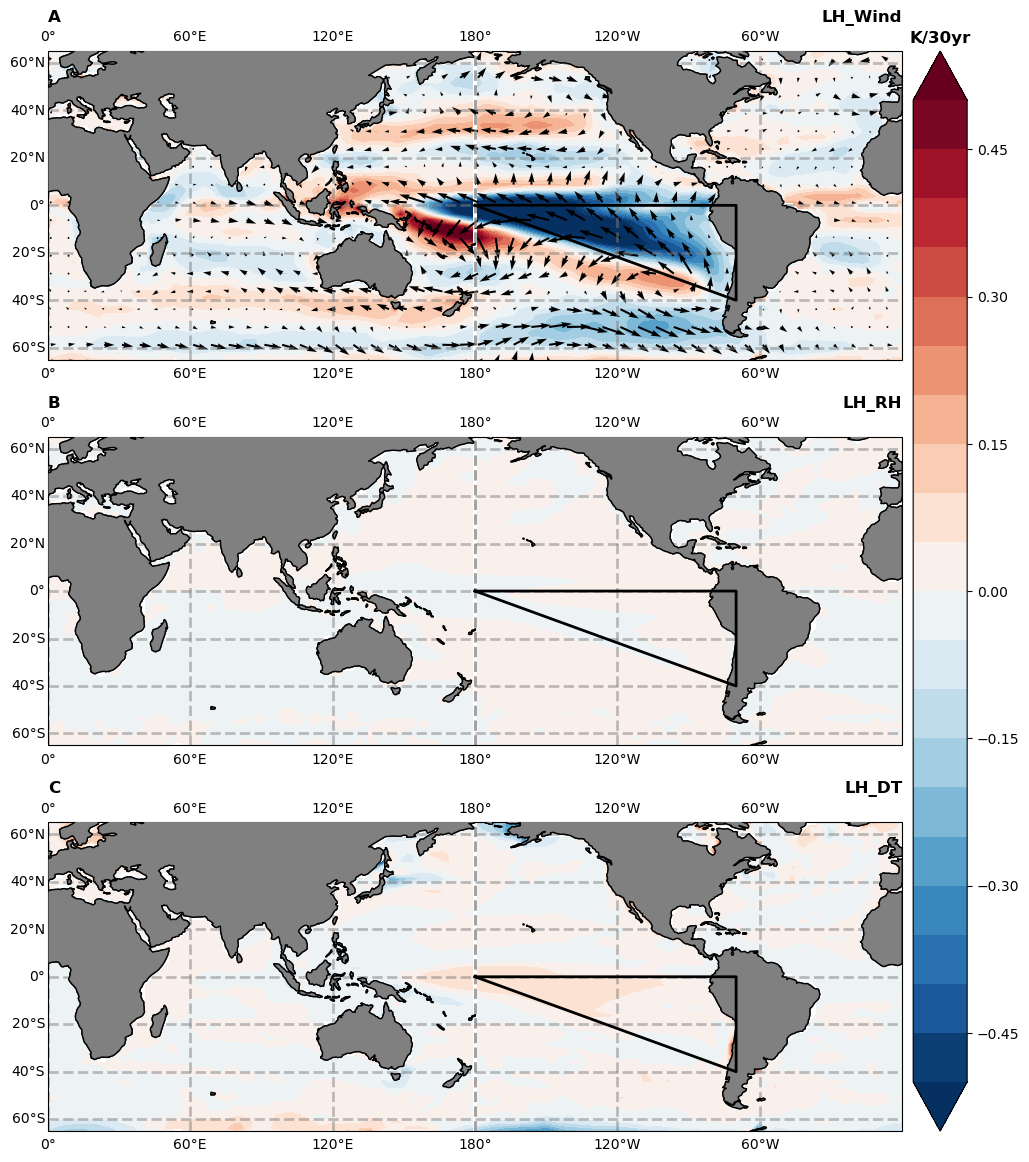

In [36]:
def global_plot(ax, data, lon, lat, cmap, pvalues=None, winds=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    if winds is not None: 
        # quiver([X, Y], U, V, [C], **kwargs)
        ax.quiver(lon[::3], lat[::3], winds["U10"][::3,::3], winds["V10"][::3,::3], scale=40, transform=ccrs.PlateCarree())
    
    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -65, 65
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

def latent_heat_components(wind, rh, dt):
    fig = plt.figure(figsize=(12,12))
    gs = GridSpec(3, 1)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180))
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.15)


    # levels = np.arange(-.65, .70, .05)
    levels = np.arange(-.5, .55, .05)
    cmap = "RdBu_r"

    img = global_plot(
        ax1,
        data=wind,
        lat=wind.lat,
        lon=wind.lon,
        winds={"U10": U10_CMIP6_1sig["U10"].to_numpy(), "V10": V10_CMIP6_1sig["V10"].to_numpy()},
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    img = global_plot(
        ax2,
        data=rh,
        lat=rh.lat,
        lon=rh.lon,
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    img = global_plot(
        ax3,
        data=dt,
        lat=dt.lat,
        lon=dt.lon,
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Set Right Title: Name of Product
    title_fontsize = 12
    ax1.set_title("LH_Wind", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title("LH_RH", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title("LH_DT", loc="right", fontweight="bold", fontsize=title_fontsize)

    ax1.set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)

    cbar = fig.colorbar(img, ax=[ax1, ax2, ax3], orientation='vertical', location="right", fraction=.1, pad=0.01)
    cbar.ax.set_title(r"K/30yr", fontsize=12, fontweight="bold")

    plt.savefig(f"Figure_SX_Wind_Components.png", dpi=400, bbox_inches='tight')


latent_heat_components(
    wind=SEB_CMIP6_1sig["W"], 
    rh=SEB_CMIP6_1sig["RH"],
    dt=SEB_CMIP6_1sig["DT"]
)

# Figure 3, 3S, 4

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def global_plot(ax, data, lon, lat, cmap, pvalues=None, winds=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    if winds is not None: 
        # Try scale=18 for Fig 4.
        q = ax.quiver(lon[::3], lat[::3], winds["U10"][::3,::3], winds["V10"][::3,::3], scale=30, headwidth=2, headlength=4, transform=ccrs.PlateCarree())
        # Add quiver key
        ax.quiverkey(q, .9, -.15, 1, str(1) + r' $\frac{m}{s}/\sigma$', labelpos='E', transform=ccrs.PlateCarree(), coordinates='axes')

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    return img

In [39]:
def figure_3(seb_cmip6, u, v, corr_cmip, p_cmip, levels, save_name="Figure_3.png", cur_fig="3"):
    axis_fontsize = 12
    title_fontsize = 20
    
    fig = plt.figure(figsize=(24,18))
    gs = GridSpec(5, 2)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180))
    ax4 = fig.add_subplot(gs[3], projection=ccrs.PlateCarree(central_longitude=180))
    ax5 = fig.add_subplot(gs[4], projection=ccrs.PlateCarree(central_longitude=180))
    ax6 = fig.add_subplot(gs[5], projection=ccrs.PlateCarree(central_longitude=180))
    ax7 = fig.add_subplot(gs[6], projection=ccrs.PlateCarree(central_longitude=180))
    ax8 = fig.add_subplot(gs[7], projection=ccrs.PlateCarree(central_longitude=180))
    ax9 = fig.add_subplot(gs[8])
    ax10 = fig.add_subplot(gs[9])
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.10)
    
    cmap = "RdBu_r"

    # Plot Figure 3a: SST Trend
    global_plot(
        ax1,
        data=seb_cmip6["NET"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["NET"].median("model", skipna=True), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Ocean
    img = global_plot(
        ax2,
        data=seb_cmip6["O"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["O"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Latent Heat Trend
    global_plot(
        ax4,
        data=seb_cmip6["LH_Other"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["LH_Other"].median("model"), 
        winds={"U10": u["U10"].to_numpy(), "V10": v["V10"].to_numpy()},
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Shortwave Cloud Trend
    global_plot(
        ax3,
        data=seb_cmip6["SWC"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["SWC"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Sensible Heat Trend
    global_plot(
        ax6,
        data=seb_cmip6["SH"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["LWC"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Longwave Cloud Trend
    global_plot(
        ax5,
        data=seb_cmip6["LWC"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["LWC"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    
    # Plot Figure 3: Cloud Trend
    global_plot(
        ax7,
        data=seb_cmip6["CLOUD"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["CLOUD"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure 3: Radiation
    global_plot(
        ax8,
        data=seb_cmip6["NON_CLOUD"],
        lat=seb_cmip6.lat,
        lon=seb_cmip6.lon,
        # pvalues=p["CLOUD"].median("model"), 
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    title_fontsize = 12
    # Title
    ax1.set_title("NET", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title("Ocean", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title("SW Cloud", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax4.set_title("LH", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax5.set_title("LW Cloud", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax6.set_title("SH", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax7.set_title("Net Cloud", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax8.set_title("Non Cloud", loc="right", fontweight="bold", fontsize=title_fontsize)

    # Lettering
    ax1.set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax4.set_title("D", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax5.set_title("E", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax6.set_title("F", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax7.set_title("G", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax8.set_title("H", loc="left", fontweight="bold", fontsize=title_fontsize)

    cbar = fig.colorbar(img, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10], orientation='vertical', location="right", fraction=.1, pad=0.01)
    # cbar = fig.colorbar(img, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], orientation='vertical', location="right", fraction=.1, pad=0.01)

    levels = [round(i, 3) for i in levels]
    cbar.set_ticks(ticks=levels, labels=levels)
    # cbar.ax.set_title(r"$K/30yr/\sigma$", fontsize=title_fontsize, fontweight="bold")
    cbar.ax.set_title(r"$\Delta [K/30yr/\sigma]$", fontsize=title_fontsize, fontweight="bold")
   
    names = list(corr_cmip.keys())
    if cur_fig == "3":
        swcf = [r**2 for _, r in corr_cmip.values()]
        seb = [r**2 for r, _ in corr_cmip.values()]
        p_swcf = [p for _, p in p_cmip.values()]
        p_seb = [p for p, _ in p_cmip.values()]
    if cur_fig == "S3":
        swcf = [r for _, r in corr_cmip.values()]
        seb = [r for r, _ in corr_cmip.values()]
        p_swcf = [p for _, p in p_cmip.values()]
        p_seb = [p for p, _ in p_cmip.values()]

    h7 = ax9.bar(np.arange(len(names)), seb, color="black", alpha=.75)
    h8 = ax10.bar(np.arange(len(names)), swcf, color="black", alpha=.75)
    
    if cur_fig == "3":
        # Add labels ontop of bars 
        for i, (b7, b8) in enumerate(zip(h7, h8)):
            i7 = np.around(b7.get_height(), 2)
            i8 = np.around(b8.get_height(), 2)
            sig7, sig8 = '', ''
            if p_seb[i] <= 0.05: sig7 = "*"
            if p_swcf[i] <= 0.05: sig8 = "*"

            ax9.text(x=b7.get_x() + b7.get_width() / 2, y=i7+.05, s=f"{i7}{sig7}", ha='center', fontsize=title_fontsize)
            ax10.text(x=b8.get_x() + b8.get_width() / 2, y=i8+.05, s=f"{i8}{sig8}", ha='center', fontsize=title_fontsize)

        # Set title
        ax9.set_title(r"$R^2[\sigma(\Delta NET), \sigma(\Delta X)]$", loc="right", fontweight="bold", fontsize=title_fontsize) 
        ax10.set_title(r"$R^2[SWCF_{EPSA}, \sigma(\Delta X)]$", loc="right", fontweight="bold", fontsize=title_fontsize) 

        ax9.set_ylim(0, 1)
        ax10.set_ylim(0, 1)

    if cur_fig == "S3":
        ax9.set_title("EPT", loc="right", fontweight="bold", fontsize=title_fontsize) 
        ax10.set_title("EPSA", loc="right", fontweight="bold", fontsize=title_fontsize) 

        ax9.set_ylim(-.15, .15)
        ax10.set_ylim(-.15, .15)

    ax9.set_title("I", loc="left", fontweight="bold", fontsize=title_fontsize) 
    ax10.set_title("J", loc="left", fontweight="bold", fontsize=title_fontsize) 

    # Add xlabels
    ax9.set_xticks(np.arange(len(names)))
    ax9.set_xticklabels(names, fontsize=axis_fontsize)
    ax10.set_xticks(np.arange(len(names)))
    ax10.set_xticklabels(names, fontsize=axis_fontsize)

    ax9.grid(); ax10.grid()

    # Reduce White Space
    plt.savefig(save_name, dpi=1200, bbox_inches = 'tight')



## Figure 3

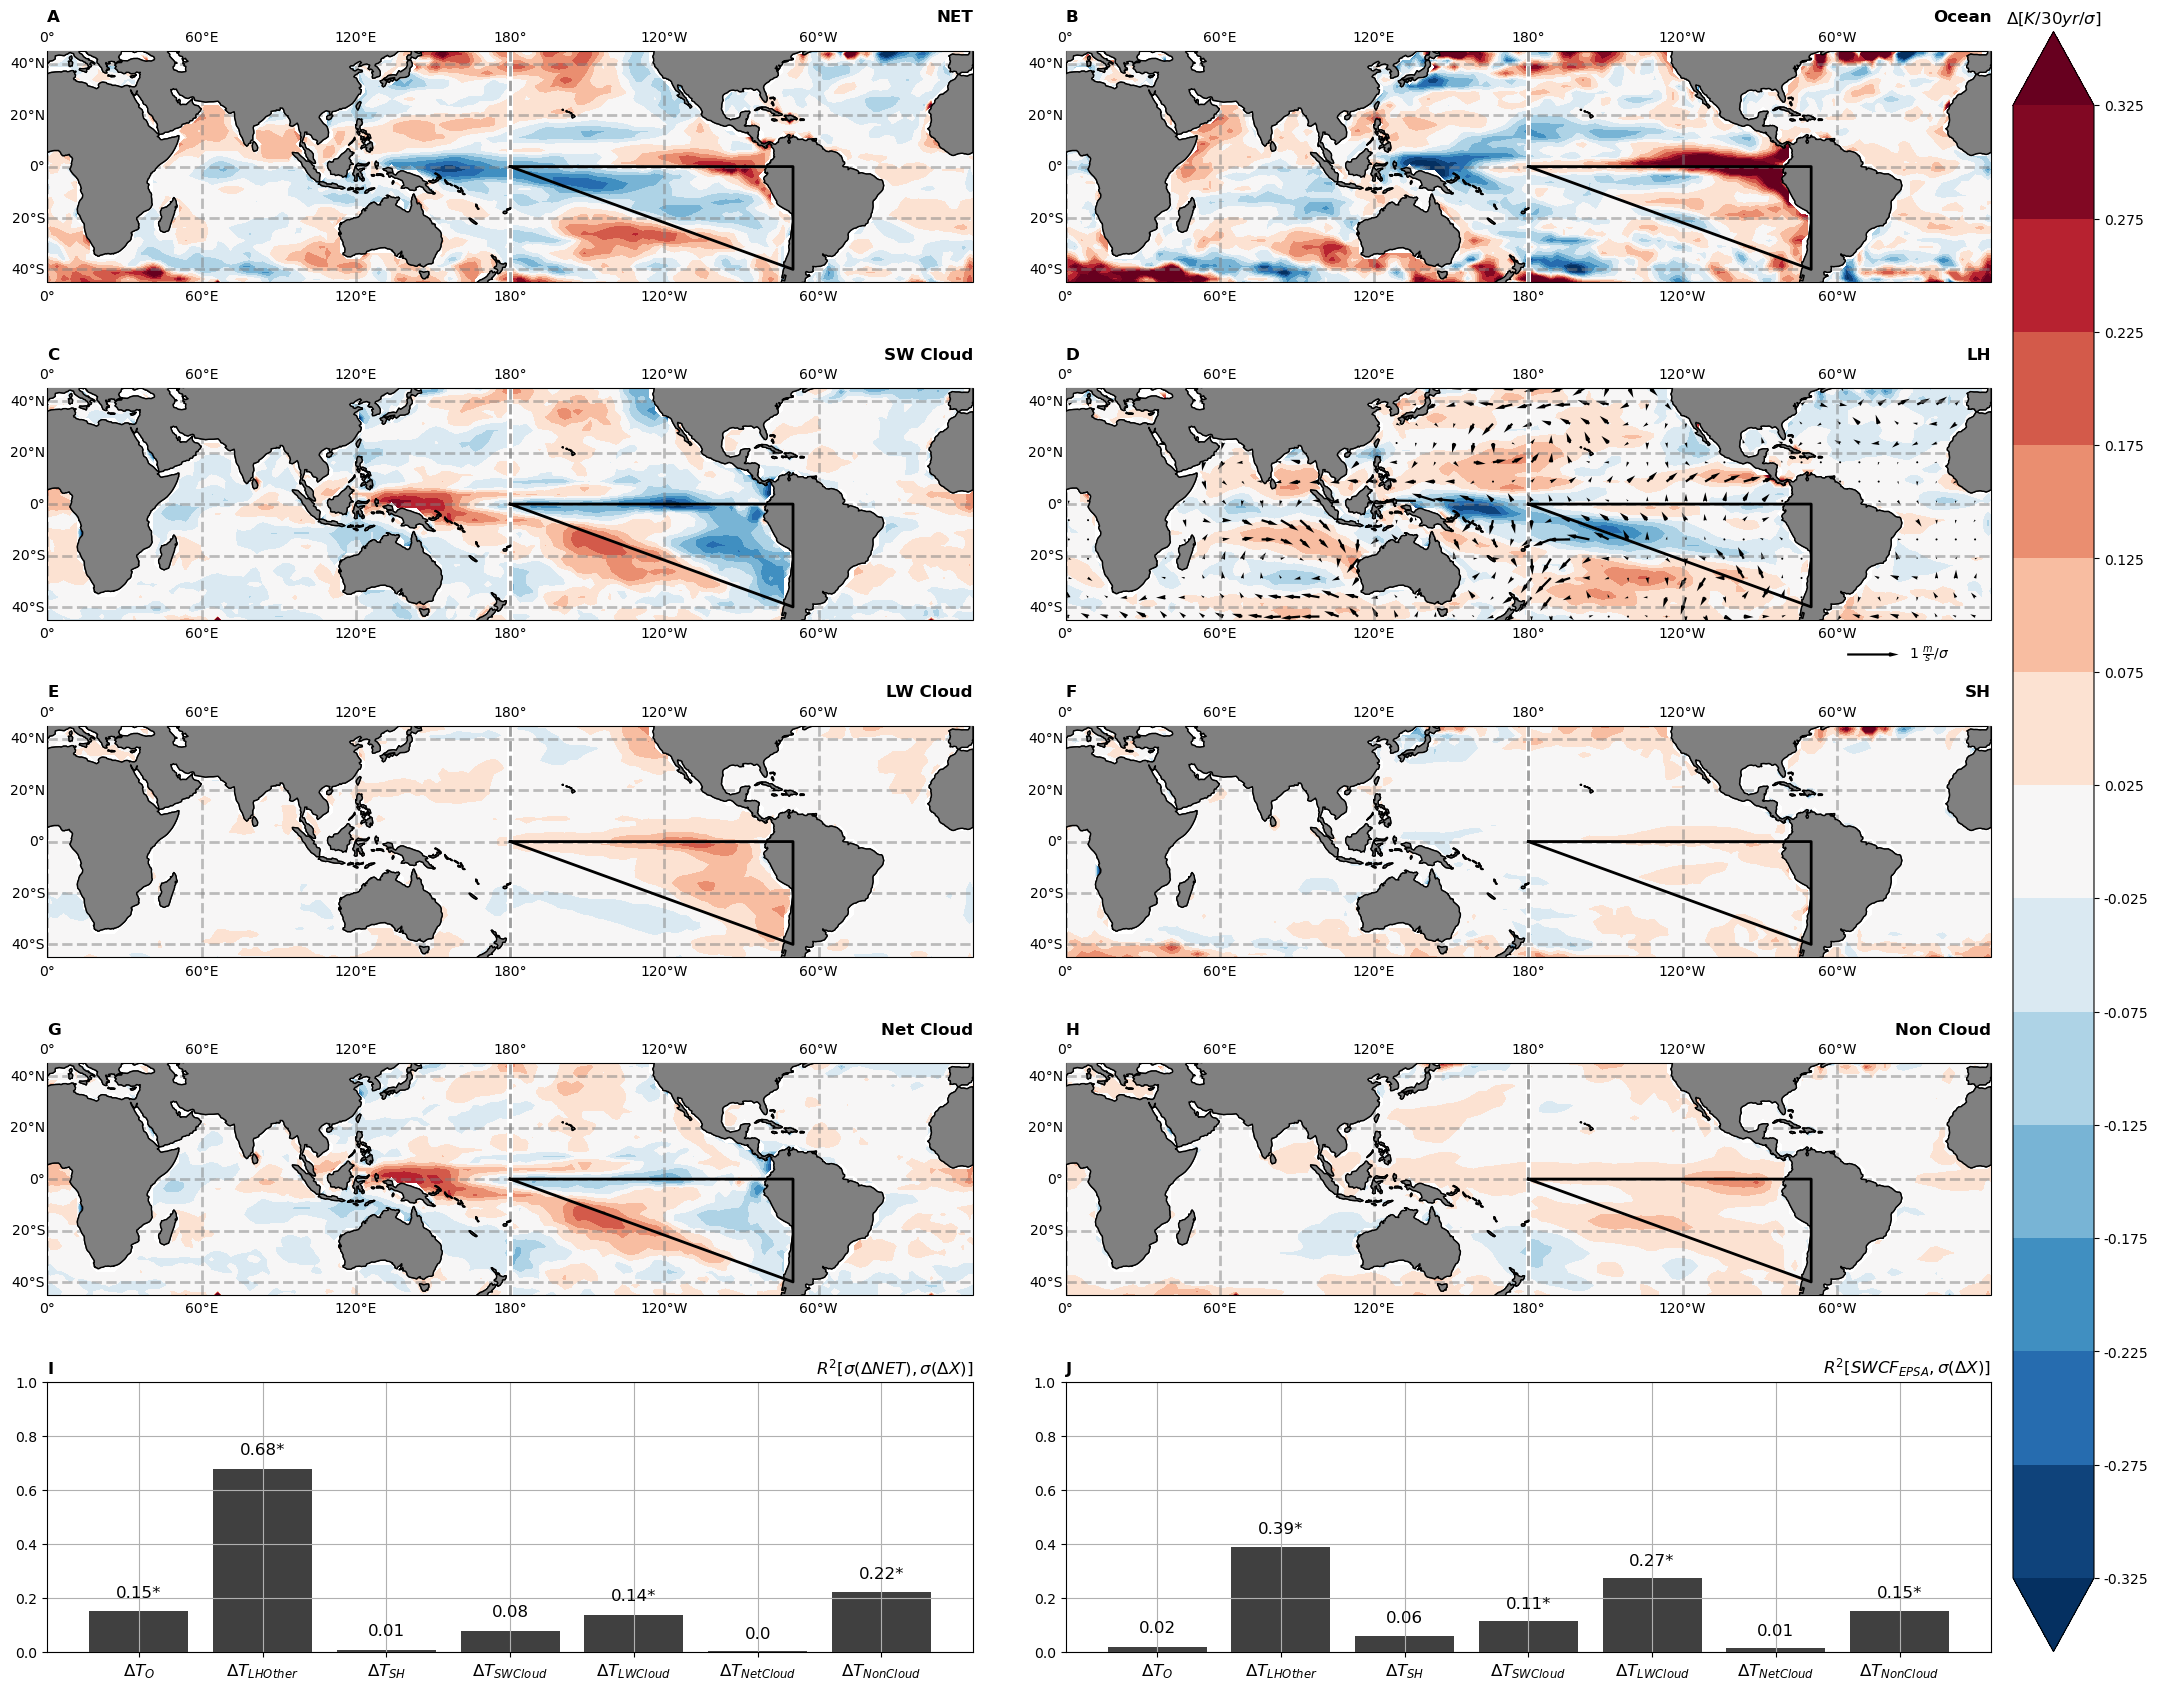

In [40]:
# trend_min, trend_max, trend_step = -0.195, 0.195, 0.03
trend_min, trend_max, trend_step = -0.325, 0.375, 0.05
levels = np.arange(trend_min, trend_max, trend_step)

idx = ["O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD"]
ticklabels = [
    r"$\Delta T_{O}$",
    r"$\Delta T_{LH Other}$", 
    r"$\Delta T_{SH}$", 
    r"$\Delta T_{SW Cloud}$", 
    r"$\Delta T_{LW Cloud}$", 
    r"$\Delta T_{Net Cloud}$",
    r"$\Delta T_{Non Cloud}$",
]

figure_3(
    seb_dif, 
    u=u10_dif,
    v=v10_dif,
    corr_cmip={ticklabels[i]: corr_cmip[key] for i, key in enumerate(idx)},
    p_cmip={ticklabels[i]: p_cmip[key] for i, key in enumerate(idx)},
    levels=levels,
    save_name="Figure_4_sig.png"
)

# Figure S3

In [61]:
sig_SEB

{'NET': (-0.3114333641207664, -0.3252655995393698),
 'O': (-0.188403325202726, -0.1401430818679102),
 'LH_Other': (-0.17222964506939775, -0.14817424473537238),
 'SH': (-0.011676452318457702, 0.006280522002130803),
 'SWC': (0.006850007938677264, -0.1197136180356362),
 'LWC': (0.050785012248016584, 0.0900472373704537),
 'CLOUD': (0.05763502018669386, -0.029666380665182485),
 'NON_CLOUD': (0.08176327820900425, 0.0822728132808237)}

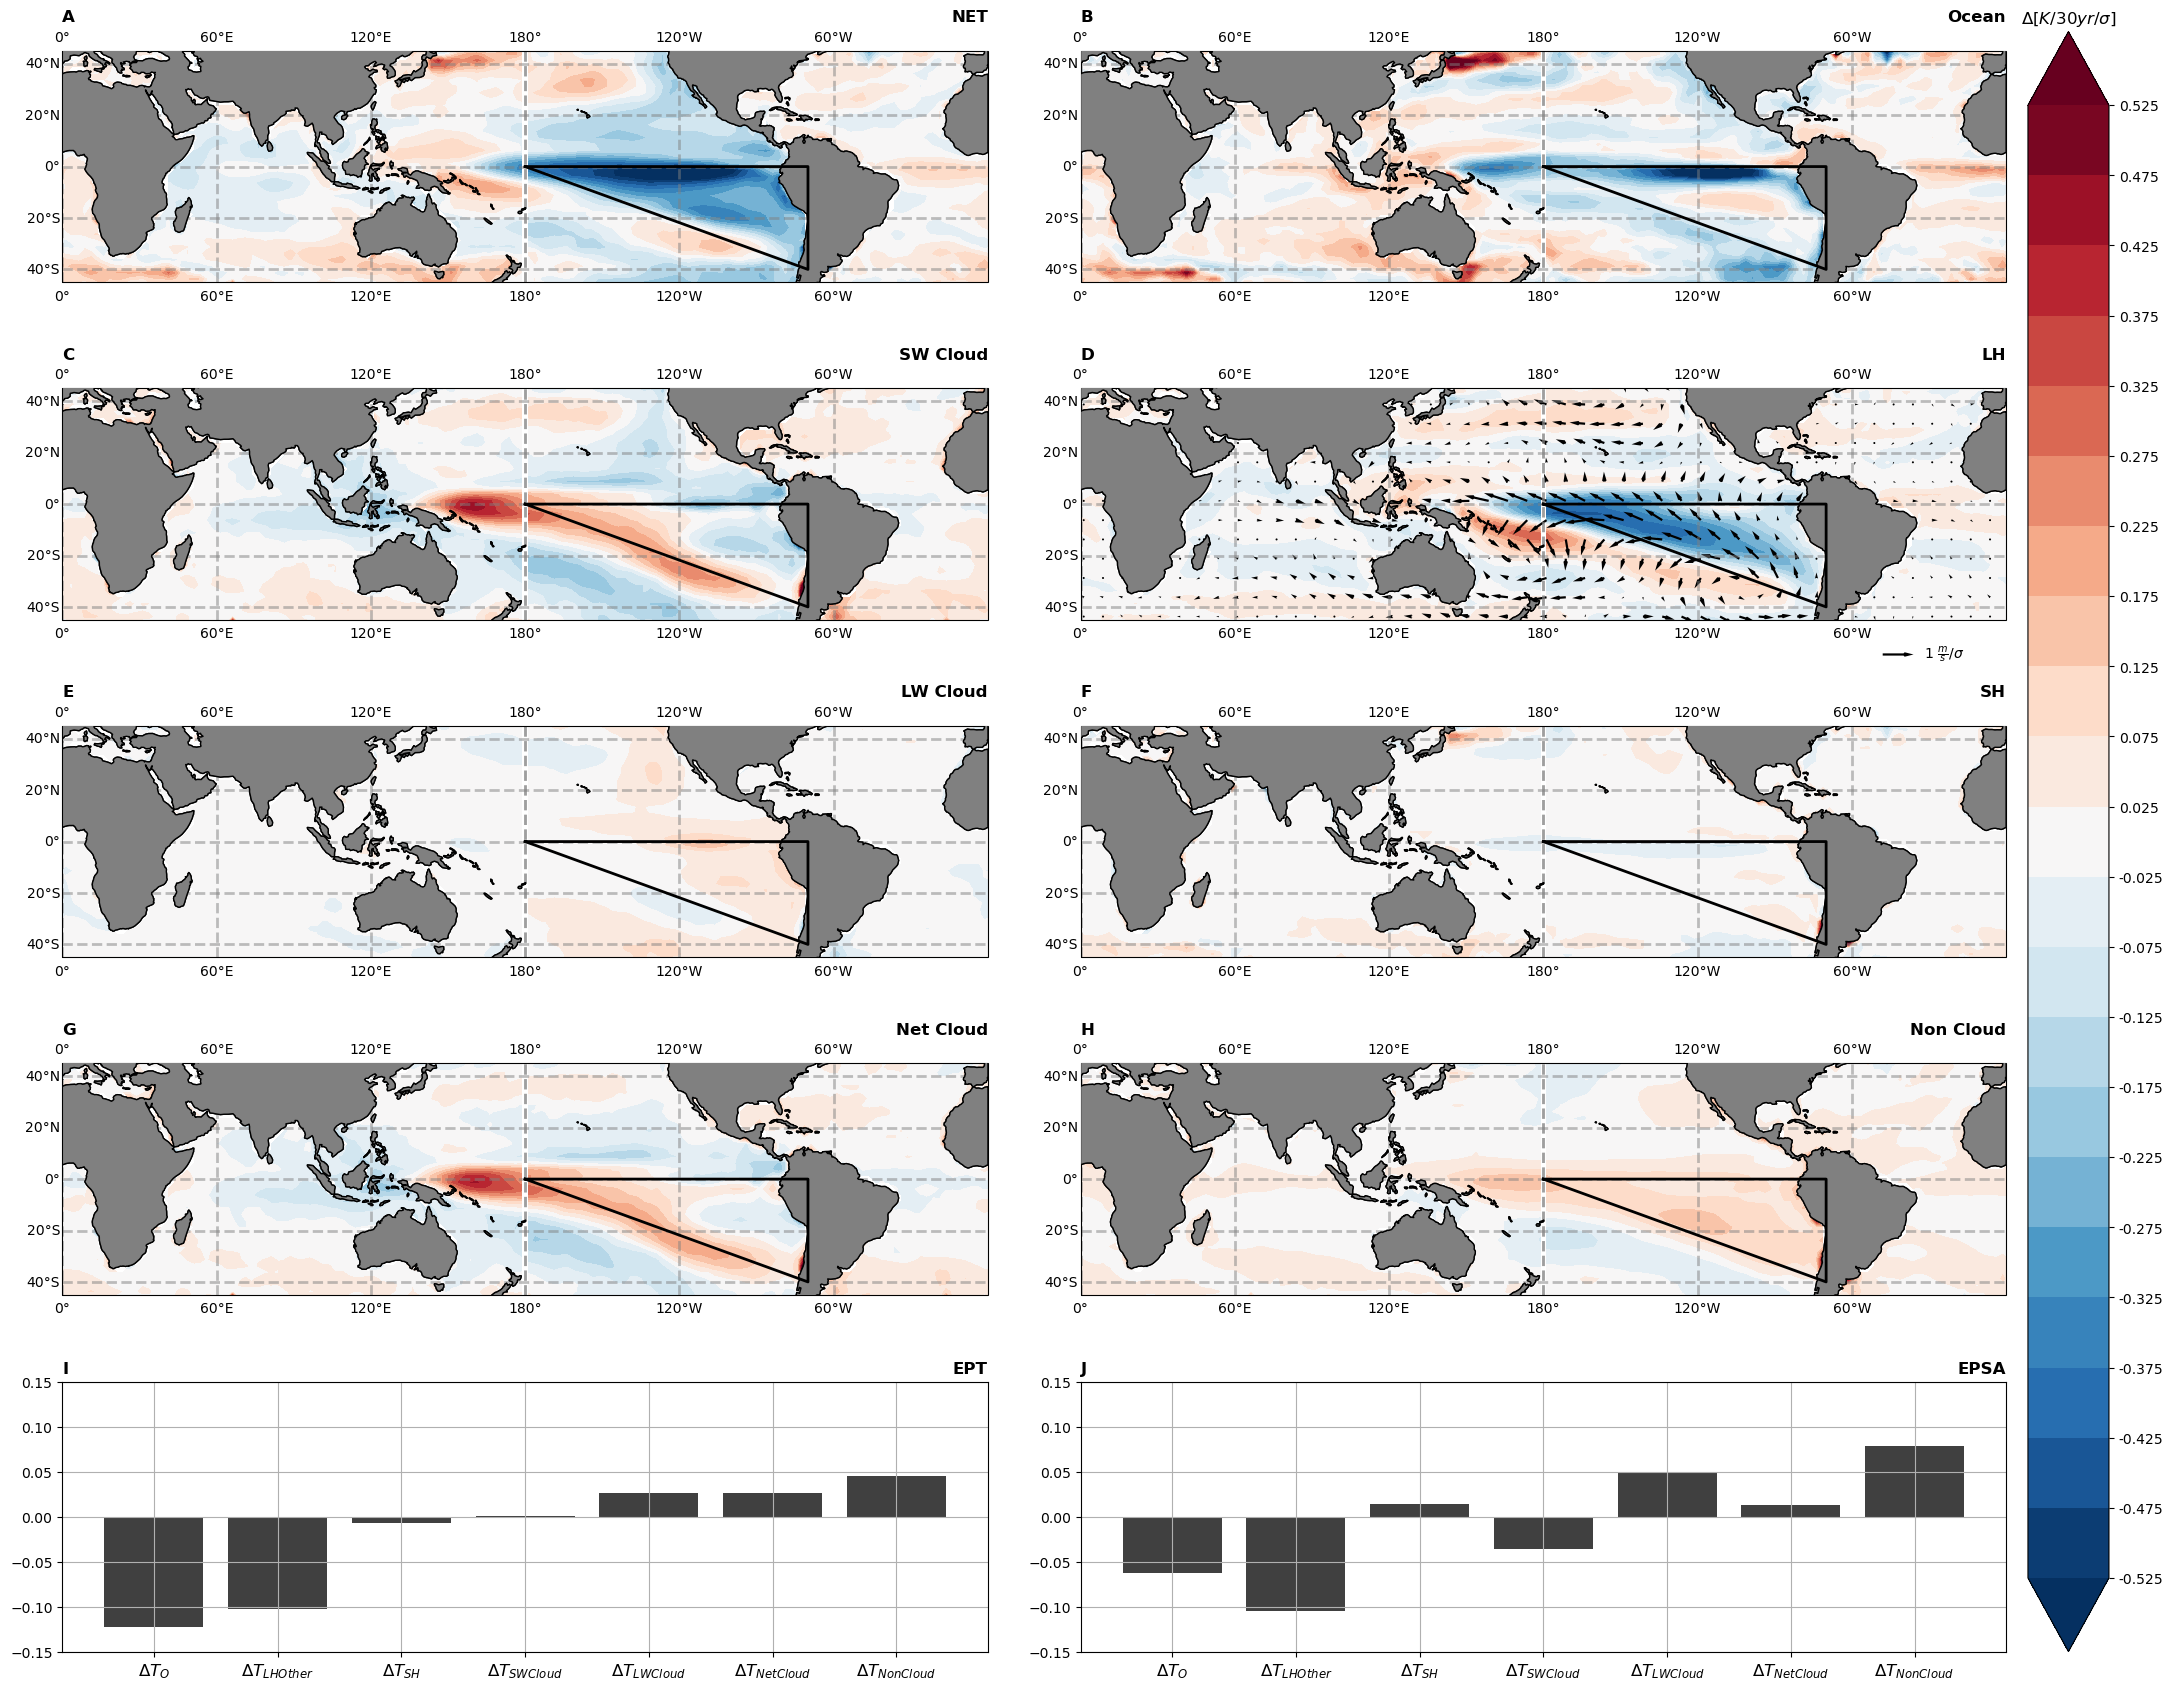

In [43]:
# trend_min, trend_max, trend_step = -0.195, 0.195, 0.03
trend_min, trend_max, trend_step = -0.525, 0.575, 0.05
levels = np.arange(trend_min, trend_max, trend_step)

idx = ["O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD"]
ticklabels = [
    r"$\Delta T_{O}$",
    r"$\Delta T_{LH Other}$", 
    r"$\Delta T_{SH}$", 
    r"$\Delta T_{SW Cloud}$", 
    r"$\Delta T_{LW Cloud}$", 
    r"$\Delta T_{Net Cloud}$",
    r"$\Delta T_{Non Cloud}$",
]

figure_3(
    seb_cmip6=SEB_CMIP6_1sig,
    u=U10_CMIP6_1sig,
    v=V10_CMIP6_1sig,
    corr_cmip={ticklabels[i]: sig_SEB[key] for i, key in enumerate(idx)},
    p_cmip={ticklabels[i]: (1,1) for i, key in enumerate(idx)},
    levels=levels,
    # save_name="Figure_S4_EPSA.png",
    save_name="Figure_3_sig.png",
    cur_fig="S3"
)

# Figure 4

In [34]:
trend_min, trend_max, trend_step = -0.425, 0.430, 0.05
levels = np.arange(trend_min, trend_max, trend_step)

idx = ["O", "LH_Other", "SH", "SWC", "LWC", "CLOUD", "NON_CLOUD"]
ticklabels = [
    r"$\Delta T_{O}$",
    r"$\Delta T_{LH Other}$", 
    r"$\Delta T_{SH}$", 
    r"$\Delta T_{SW Cloud}$", 
    r"$\Delta T_{LW Cloud}$", 
    r"$\Delta T_{Net Cloud}$",
    r"$\Delta T_{Non Cloud}$",
]

figure_3(
    SEB_SO_1sig, 
    u=U10_SO_1sig,
    v=V10_SO_1sig,
    corr_cmip={ticklabels[i]: corr_cmip[key] for i, key in enumerate(idx)},
    p_cmip={ticklabels[i]: p_cmip[key] for i, key in enumerate(idx)},
    levels=levels,
    save_name="Figure_4.png"
)

NameError: name 'SEB_SO_1sig' is not defined